In [1]:
# Import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# # Python SQL toolkit and Object Relational Mapper

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
measurements = base.classes.measurement
stations = base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis


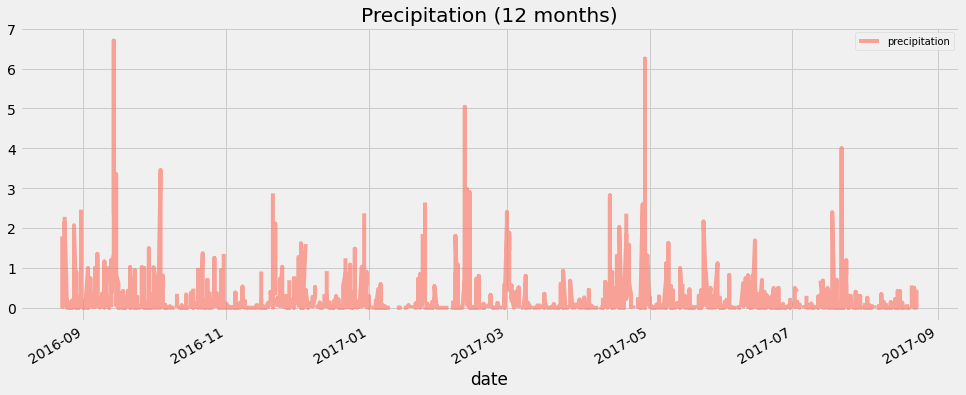

In [9]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

date_last_year = session.query(measurements.date).order_by(measurements.date.desc()).first()[0]

#find date 12 months before

prior_year = dt.datetime.strptime(date_last_year, "%Y-%m-%d") - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores

data_query = session.query(measurements.date, measurements.prcp).filter(measurements.date >= prior_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(data_query,columns=['date', 'precipitation'])

# Change datatype from element to datetime object on Pandas
precip_df['date'] = pd.to_datetime(precip_df['date'], format='%Y-%m-%d')

# Set index to date column
precip_df.set_index('date', inplace=True)

# Sort the dataframe by date
precip_df = precip_df.sort_values(by='date',ascending=True)

precip_df.head(20)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(title="Precipitation (12 months)", color='salmon', alpha=0.7, figsize=(15,6))
plt.legend(prop={'size': 10})

In [10]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(stations.station).count()
print(f"This dataset contains {station_count} unique stations.")

This dataset contains 9 unique stations.


In [11]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = session.query(stations.station, stations.name, func.count(measurements.station)).\
    filter(measurements.station == stations
.station).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc())
station_count_df = pd.DataFrame(station_count, columns = ["Station ID","Station Name","Activity Count"])

station_count_df

,Station ID,Station Name,Activity Count
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
selected = [func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs), func.count(measurements.tobs)]
temps = session.query(*selected).\
    filter(measurements.station == 'USC00519281')
    
for rec in temps:
    print(f"For Station USC00519281:")
    print(f"Min Temprature is: {rec[0]}")
    print(f"Max Temprature is: {rec[1]}")
    print(f"Average Temprature is: {round(rec[2], 1)}")

For Station USC00519281:
Min Temprature is: 54.0
Max Temprature is: 85.0
Average Temprature is: 71.7


Text(0.5, 0, 'Temperature (F)')

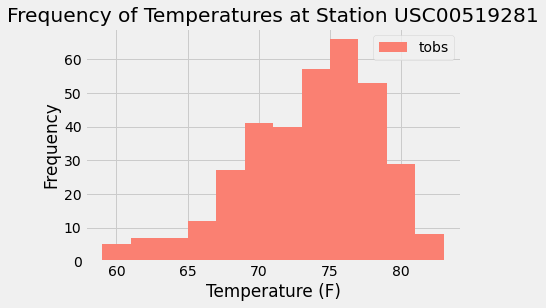

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
high_temps = session.query(measurements.tobs,measurements.date).\
    filter(measurements.date >= prior_year).\
        filter(measurements.station == 'USC00519281').\
            order_by(measurements.date.asc()).\
                all()
# turn query into a dataframe

high_temps_df = pd.DataFrame(high_temps).set_index('date').sort_index(ascending=True)

# plot the dataframe

high_temps_df.plot(kind='hist',bins=12,color = "salmon")
plt.title(f"Frequency of Temperatures at Station USC00519281")
plt.ylabel('Frequency')
plt.xlabel('Temperature (F)')
